# Generation of Radio 2D postage stamps from T-RECS catalogues
Author: Julien Girard, julien.girard@cea.fr, Version: 1, 14/12/2020

----
### 1 - Usage
Simply follow this notebook to generate a postage stamp of a realistic Star Forming Galaxy in radio band.

### 2 - Requirements
You will need to have the following dependencies:
- numpy, scipy, matplotlib
- astropy, fits
- galsim

### 3 - Catalogues
The dataset is composed of two source type: Star-Forming Galaxies (SFG) (check Bonaldi et al. for details)
- catalogue_SFGs_complete_deep.fits
- catalogue_SFGs_complete_medium.fits
- catalogue_SFGs_complete_wide1.fits      [1 to 10]

### 4 - References
* Bonaldi et al. 2018: https://arxiv.org/abs/1805.05222
* Links to datasets: 
    * .DAT: http://cdsarc.u-strasbg.fr/viz-bin/qcat?VII/282
    * .FITS: http://cdsarc.u-strasbg.fr/ftp/VII/282/fits/

------

In [43]:
import numpy as np
import galsim
from astropy.io import ascii
from astropy.io import fits
import matplotlib.pyplot as plt
from numpy.fft import rfft,fft,fftshift
from scipy import random
import MakePSF

%matplotlib inline

### Galaxy image generation parameters

We need to initialize the main parameters for image generation, as T-RECS is only a catalogue of physical parameters of the objects.

In [35]:
np.random.seed(42)   # Initializing seed for reproducibility

Npix=128             # Size of image
pixelscale=0.24      # Size of pixel in arcsec on the sky. Helps sampling the images w.r.t. catalogues.
stampimage = galsim.ImageF(Npix, Npix, scale=pixelscale)
b=galsim.BoundsI(1,Npix,1,Npix)
stamp=stampimage[b]

At this stage, `pixelscale` is arbitrary and is latter used for object selection in the catalog in a range of size

In [7]:
FFTBIGSIZE=81488  # Max size of support for Galsim (Caching the FFT)
big_fft_params=galsim.GSParams(maximum_fft_size=FFTBIGSIZE)   # to precalculate large support.

Since there is no equivalent for radio of
```python
catalog = galsim.COSMOSCatalog()
gal = catalog.makeGalaxy()
```


we need to build the galsim object by hand with the following lines:

In [8]:
image = galsim.ImageF(Npix, Npix, scale=pixelscale) # initialize container
b=galsim.BoundsI(1,Npix,1,Npix)
image=image[b]

## Simulating Star Forming Galaxy at 1400 MHz

We simulate resolved objects in radio in the "L-band" (1-2 GHz) that is the default observing band of MeerKAT. The 'default' available frequency is 1400 MHz (close to the the HI line frequency at 1420 MHz).

### 1) Opening T-RECS catalogue

One of the SFG data files should be placed next to the notebook. Here, we are using only `catalogue_SFGs_complete_wide1.fits` directly downloaded from this [ftp server](http://cdsarc.u-strasbg.fr/ftp/VII/282/fits/). This file only covers objects inside a field of 400 deg$^2$, with a 1.4 GHz lower flux density limit of 100 nJy with no clustering of sources.
The catalogue comes with the following format:

In [9]:
catalogsfg=fits.open('catalogue_SFGs_complete_wide1.fits')                                                
catalogsfg.info()

Filename: catalogue_SFGs_complete_wide1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  Catalogue     1 BinTableHDU    197   4418708R x 47C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


>There are 4418708 objects and 47 available parameters for each (geometrical parameters, flux density at all frequencies described in the paper).

In [10]:
# retrieve angular size, and ellipticities
cat1=catalogsfg[1]               # Selecting the first slice of the Fits ("Catalogue")
catdatasfg=cat1.data             # Extract data from slice
flux1400sfg=catdatasfg['I1400']  # Flux density at 1400 MHz (in Janskys)

sizesfg=catdatasfg['size']       # angular size on the sky (in arcsec)
e1=catdatasfg['e1']              # first ellipticity
e2=catdatasfg['e2']              # second ellipticity

>`I1400` corresponds to the Flux density of Stokes I (total intensity = unpolarized) at 1400 MHz. The flux density unit is in Janskys ($1\;\text{Jy} = 10^{-26} W.m^{-2}.Hz^{-1}$).

### 2) Randomly draw one object among the catalogue

We want a "resolved" object on a small support, therefore, we filter the catalogue to only get objects that are in a chosen range of size.

In [36]:
# Filtering objects that are larger than 10 pixels and
# smaller than 70 pixels on the sky.
# typical values for the array and frequency.
minpixsize=10
maxpixsize=70

filterobj=np.logical_and(sizesfg > minpixsize*pixelscale, sizesfg <maxpixsize*pixelscale)
listindexobj=np.where(filterobj == True)[0] # list of indices where condition is true
Ntotobj=len(listindexobj)                   # number of objects fitting the condition
print(Ntotobj)

171287


In [37]:
IDXsource=1878304  # Source index in selected array
#np.random.choice(listindexobj) # take 1 random source  # uncomment if you want to draw another source index

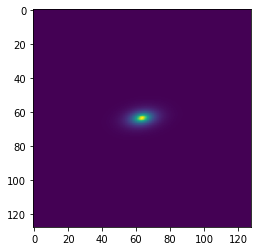

In [42]:
# Generate Star-forming galaxies (T-RECS) and plotting
f=plt.figure()
fluxsource=flux1400sfg[IDXsource]
e1gal=e1[IDXsource]
e2gal=e2[IDXsource]

# as the object is "fully" defined manually, a better galsim approach can be done here:
gauss_gal=galsim.Gaussian(fwhm=sizesfg[IDXsource],flux=fluxsource)
gal = galsim.Exponential(half_light_radius=gauss_gal.half_light_radius, flux=fluxsource, gsparams=big_fft_params)
ellipticity = galsim.Shear(e1=e1gal,e2=e2gal)
gal = gal.shear(ellipticity)
gal2=gal.drawImage(stamp,scale=pixelscale)
plt.imshow(gal2.array)

### 3) Generate radio ~realistic noise

The measurement space in radio interferometry is the Fourier space. A collection of Fourier components is measured for each time, frequency, direction. Each interferometric baseline (projected from the physical baseline to the apparent baseline, "as seen from the source") is associated with the corresponding ($u$,$v$,$w$) components in the Fourier domain.

Noise of the measurement of Fourier component can be considered as a white centered gaussian noise in the Fourier plane. However, in the image space, this noise will be correlated.

In summary, the convolved sky will have a noise background consisting of : i) additional measurement noise in the Fourier space, ii) the spatial noise created by unmeasured Fourier components.

Components are non-zero in "mask" $M$ defined as: 
$$ FT(PSF \star S ) \leftrightarrow \text{M} \times \hat{S}$$



SNR in Radio images is usually estimated a follows:  $$SNR=\frac{\text{Peak Flux density}}{\sigma_{empty}}$$ where
- Peak Flux density, is the source maximum flux density, in Jy.
- $\sigma_{empty}$, is a local standard-deviation of a source-free patch, in the image, close to the source. /!\ therefore, the object size should be reasonable to enable computation of the image SNR.

Noise generation process:
- a) create a random noise map on half the PSF support
- b) make the noise symmetric to reproduce the measurement of ($u$,$v$) and ($-u$,$-v$)

In [73]:
# Creating noise map of specific sigma level, for both real part and imaginary part over half of the image.
additive_noise_level=10.0
Noisemap_RE=np.random.normal(0,additive_noise_level,size=(Npix,Npix//2))
Noisemap_IM=np.random.normal(0,additive_noise_level,size=(Npix,Npix//2))
Noisemap_C=(Noisemap_RE+1j*Noisemap_IM)/np.sqrt(2)

np.std(Noisemap_C)

9.972192477802801

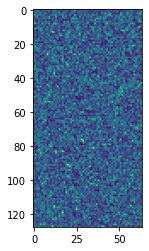

In [75]:
plt.imshow(np.abs(Noisemap))

In [54]:
Noisemap=np.random.normal

In [ ]:
rfft2d

### 4) MeerKAT PSF parameters

We used MeerKAT 64 antennes as a baseline radiointerferometer working in L-band (around 1420 MHz).
Location of MeerKAT on Earth is: Long=21.33°,Lat=-30.83°, h=1195 m.

In [6]:
# Initialized parameters
# Specific parameters to generate Radio interferometric PSF from observational constraints with MeerKAT.
# Radio PSF are frequency, time, direction and exposure dependent. Therefore, observational parameters should be specified or fixed to reasonable values.
Obs_start='2020-10-05T20:00:00' # in Universal Time (UT)
Obs_end='2020-10-06T04:00:00' # in UT  # [Obs_start, Obs_end] define the exposure time

#Npix=128 # PSF Support size, should be same or twice the postage stamp.
FoV=0.1 # Field of View (in degrees) ===> gives size of pixel on the sky. Should be compatible with galaxy size range in degrees.
Pointing_RA=5.4     # Right ascension in degrees. (15° = 1h of RA)
Pointing_DEC=-30.83 # Declination in degrees.

F=1420.e6 # Observing frequency in Hz.

In [12]:
# Make the radio PSF

Pointing=SkyCoord(Pointing_RA,Pointing_DEC,unit='deg')
tstart=Time(Obs_start,format='isot',scale='utc')
tend=Time(Obs_end,format='isot',scale='utc')
tstep=TimeDelta(delta_t,format='sec')

uvw=MakePSF.UVW(timetab,MakePSF.MeerKATarr.Array,f)
timetab=Time([tstart+i*tstep for i in range(int(Ndates))])


NameError: name 'SkyCoord' is not defined

### Noise simulation parameters

###### c) Create galaxies and store in np array